In [6]:
from plots.plot_utils import load_pickle
data = load_pickle("boston_lossscaled_batch_cal_ens1_bootFalse_seed0_thres0.01-0.15.pkl")

In [7]:
for entry in zip(data['te_ece_list_best'], data['te_sharp_score_list_best']):
    print(entry)

(0.07363636363636362, 0.0935474103877344)
(0.07505050505050503, 0.0935474103877344)
(0.07646464646464644, 0.0935474103877344)
(0.07787878787878787, 0.0935474103877344)
(0.07929292929292928, 0.09023073559270757)
(0.08070707070707069, 0.09023073559270757)
(0.08212121212121211, 0.09023073559270757)
(0.08353535353535352, 0.09023073559270757)
(0.08494949494949493, 0.09023073559270757)
(0.08636363636363635, 0.0891461115674571)
(0.08777777777777776, 0.0891461115674571)
(0.08919191919191917, 0.0891461115674571)
(0.09060606060606059, 0.0851996906155015)
(0.092020202020202, 0.0851996906155015)
(0.09343434343434341, 0.0851996906155015)
(0.09484848484848483, 0.0851996906155015)
(0.09626262626262624, 0.0851996906155015)
(0.09767676767676765, 0.0851996906155015)
(0.09909090909090908, 0.0851996906155015)
(0.10050505050505049, 0.0851996906155015)
(0.1019191919191919, 0.0851996906155015)
(0.10333333333333332, 0.0851996906155015)
(0.10474747474747473, 0.0851996906155015)
(0.10616161616161614, 0.08519969

In [8]:
from utils.misc_utils import EceSharpFrontier
frontier = EceSharpFrontier.from_list(list(zip(data['te_ece_list_best'], data['te_sharp_score_list_best'])), only_frontier=True)

In [9]:
thresholded_frontiers = frontier.get_thresholded_frontier()
import matplotlib.pyplot as plt
# [{'ece': 0.07363636363636362, 'sharp': 0.0935474103877344, 'model': None},
# {'ece': 0.07505050505050503, 'sharp': 0.0935474103877344, 'model': None},
ece_list = [entry['ece'] for entry in thresholded_frontiers]
sharp_list = [entry['sharp'] for entry in thresholded_frontiers]

plt.scatter(ece_list, sharp_list)

TypeError: 'EceSharpFrontier' object is not iterable

In [ ]:
for entry in zip(data['thresholds'], data['va_ece_list_best'], data['va_sharp_score_list_best']):
    print(entry)

In [ ]:
len(data['thresholds'])

In [10]:
import glob
pkls = glob.glob("results/boston*.pkl")
from plots.plot_utils import load_pickle 
objs = []
for pkl in pkls:
    data = load_pickle(pkl)
    objs.append((data, str(pkl)))


In [11]:
len(objs[0])

2

In [12]:
ece_sharpness = []
for obj, pkl in objs:
    ece_sharpness.append((obj['te_ece_list_best'], obj['te_sharp_score_list_best'], pkl))

In [13]:
len(ece_sharpness)

3

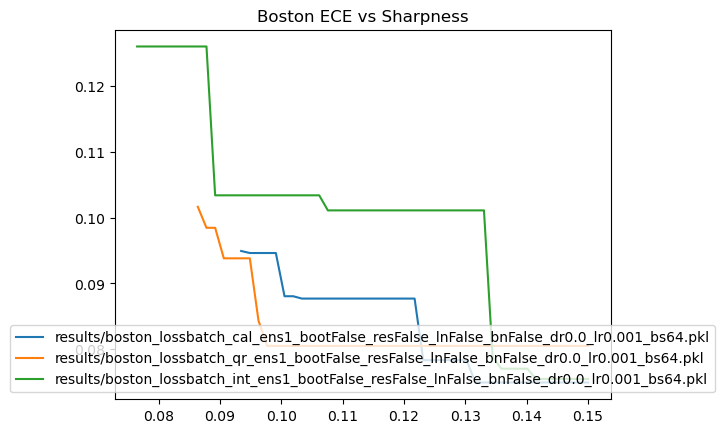

In [18]:
import matplotlib.pyplot as plt

for ece, sharpness, pkl in ece_sharpness:
    plt.plot(ece, sharpness, label=pkl)
    plt.title("Boston ECE vs Sharpness")
    plt.legend(loc="lower center")

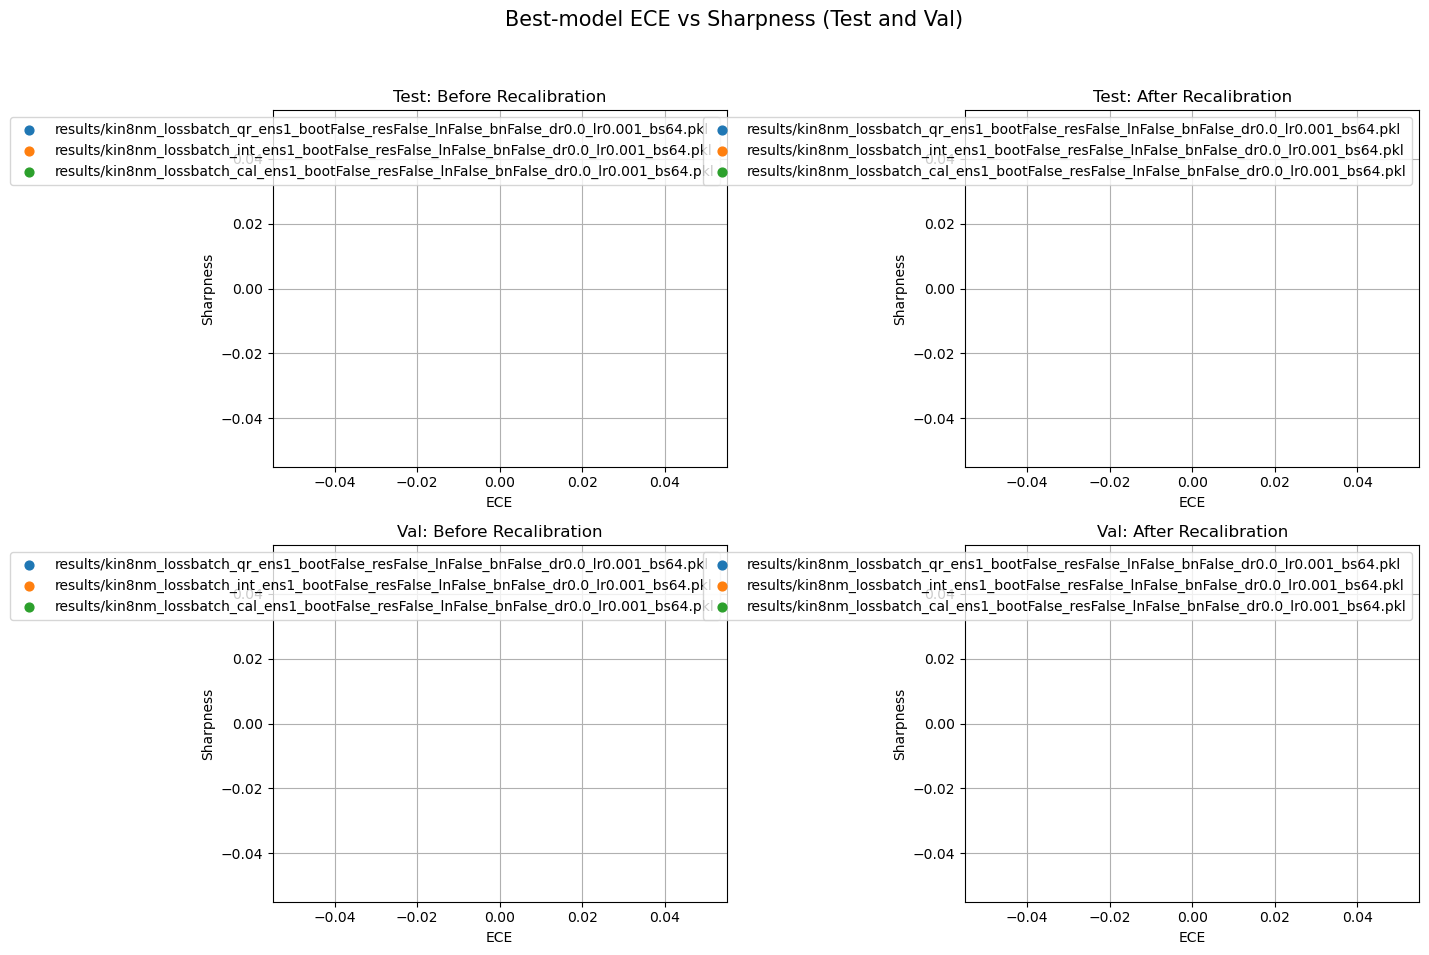

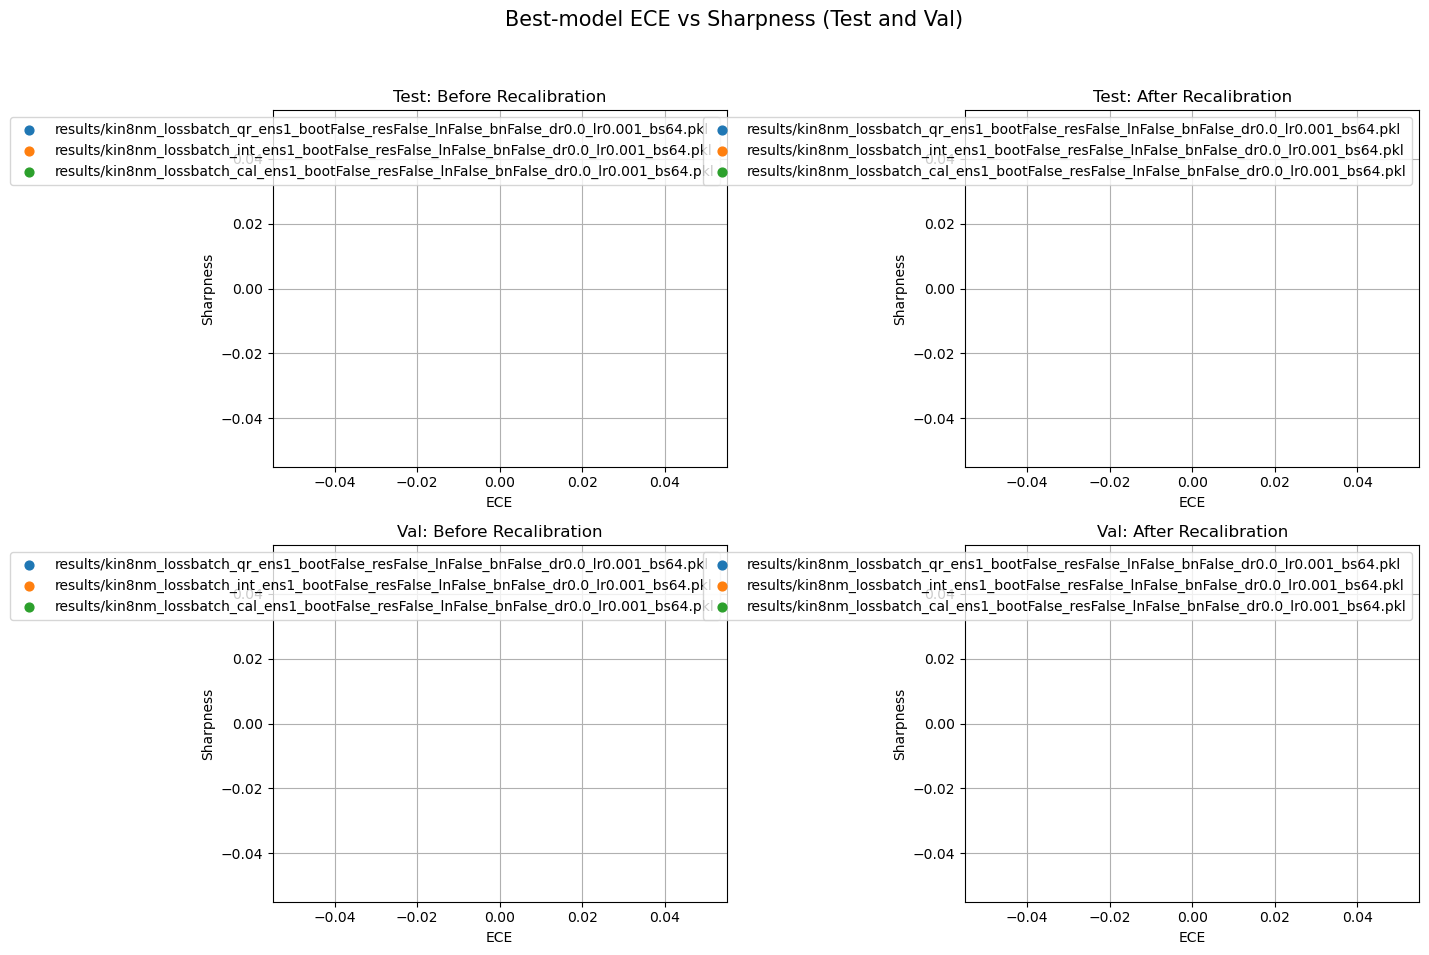

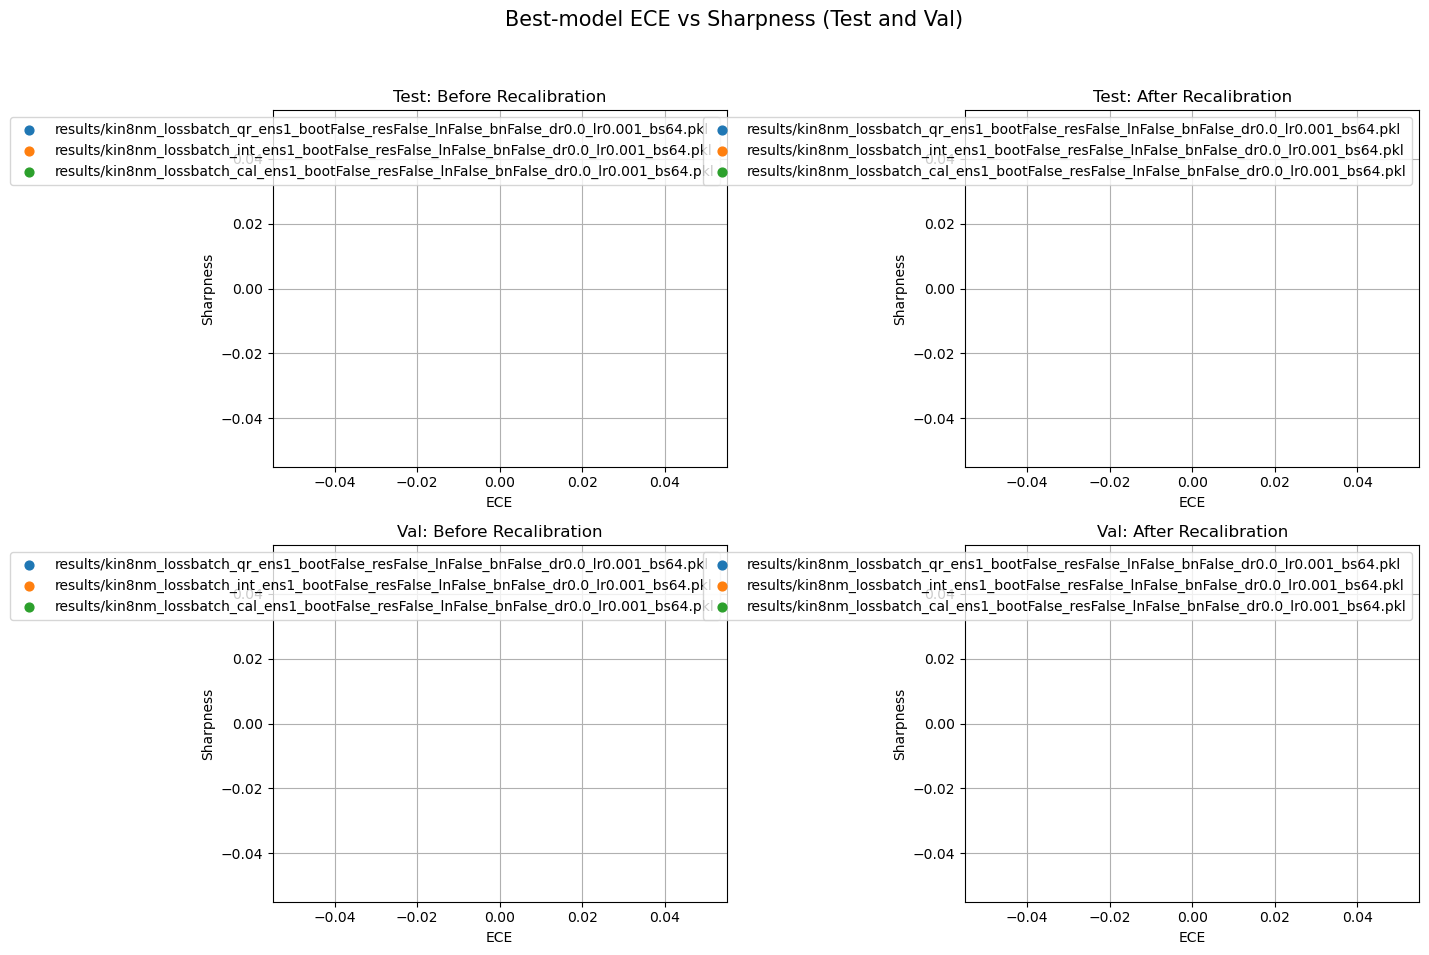

In [11]:
from plots.plot_metrics import overlap_ece_sharpness
from plots.plot_utils import load_pickle
import os
results_dir = "results"
names = ["batch_qr", "batch_int", "batch_cal"]
example_pkl = "kin8nm_lossbatch_cal_ens1_bootFalse_resFalse_lnFalse_bnFalse_dr0.0_lr0.001_bs64.pkl"
example_pkls = ["{}/{}".format(results_dir, example_pkl.replace("batch_cal", name)) for name in names]
for pkl in example_pkls:
    datas = [load_pickle(pkl) for pkl in example_pkls]
    overlap_ece_sharpness(datas, example_pkls, show=True)

In [ ]:
example_pkls

['/home/scratch/yixiz/results/kin8nm_lossbatch_qr_ens1_bootFalse_resFalse_lnFalse_bnFalse_dr0.0_lr0.01_bs64',
 '/home/scratch/yixiz/results/kin8nm_lossbatch_int_ens1_bootFalse_resFalse_lnFalse_bnFalse_dr0.0_lr0.01_bs64',
 '/home/scratch/yixiz/results/kin8nm_lossbatch_cal_ens1_bootFalse_resFalse_lnFalse_bnFalse_dr0.0_lr0.01_bs64']